# ML Final Project: Plant Disease Classification

by Kevin Howlett

In [1]:
#:::::::::::: LIBRARIES :::::::::::::#
#::::::::::::::::::::::::::::::::::::#

# Standard
import math as mt 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import time
import os
import copy
import glob
import cv2

# Sklearn
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder

## Brief Overview

The goal of this project was to classify images of edible crop leaves by their species/disease pair. These images were found Kaggle (https://www.kaggle.com/vipoooool/new-plant-diseases-dataset). The dataset consisted of about 70,000 training images and 18,000 testing images, all 256x256 pixels with 3 RGB color channels. The results of this project have implications in agriculture, since an efficient classification algorithm can mitigate the need for an expert to identify diseases in crops, saving both time and money for farmers or anyone who wishes to identify plant diseases.   

The algorithms used here include a random forest model (65.1% validation accuracy) and a ResNet-18 transfer CNN model (93.4% validation accuracy).

In [11]:
data_dir = "/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

There are 38 classes (disease/plant pairs).

In [12]:
diseases

['Strawberry___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Blueberry___healthy',
 'Corn_(maize)___healthy',
 'Tomato___Target_Spot',
 'Peach___healthy',
 'Potato___Late_blight',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Pepper,_bell___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Leaf_Mold',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Cherry_(including_sour)___Powdery_mildew',
 'Apple___Cedar_apple_rust',
 'Tomato___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy',
 'Tomato___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Apple_scab',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_

In [13]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

We can see that the plants are all edible crop plants, below. It is especially useful to be able to identify diseases within these plants because it can be a huge money/time saver when working in agriculture.  

14 total plant species:

In [14]:
plants

['Strawberry',
 'Grape',
 'Potato',
 'Blueberry',
 'Corn_(maize)',
 'Tomato',
 'Peach',
 'Pepper,_bell',
 'Orange',
 'Cherry_(including_sour)',
 'Apple',
 'Raspberry',
 'Squash',
 'Soybean']

We can see a relatively uniform distribution of classes below:

In [24]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
img_per_class = pd.DataFrame(nums.items(), columns=["Disease", "Total"])

px.bar(img_per_class, x = "Disease", y = "Total")

## CNN

In [2]:
###################
## TRAINING DATA ##
###################

data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

train_dataset

Dataset ImageFolder
    Number of datapoints: 70295
    Root location: /Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
    StandardTransform
Transform: ToTensor()

In [3]:
###############
## TEST DATA ##
###############

data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

test_dataset

Dataset ImageFolder
    Number of datapoints: 17572
    Root location: /Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
    StandardTransform
Transform: ToTensor()

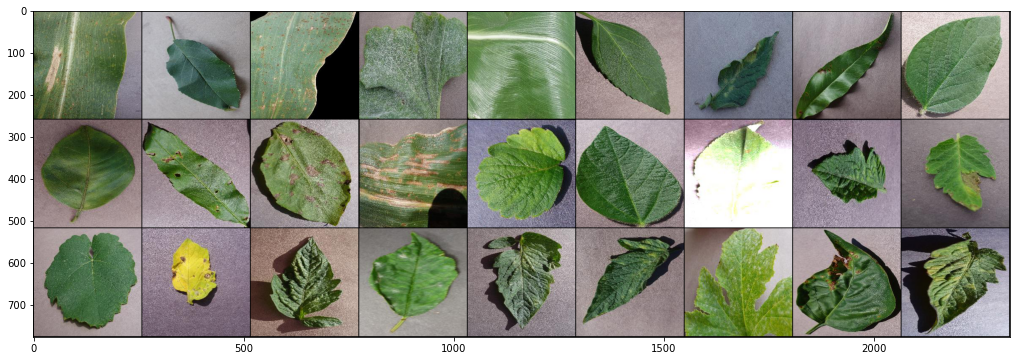

In [4]:
for images,labels in train_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

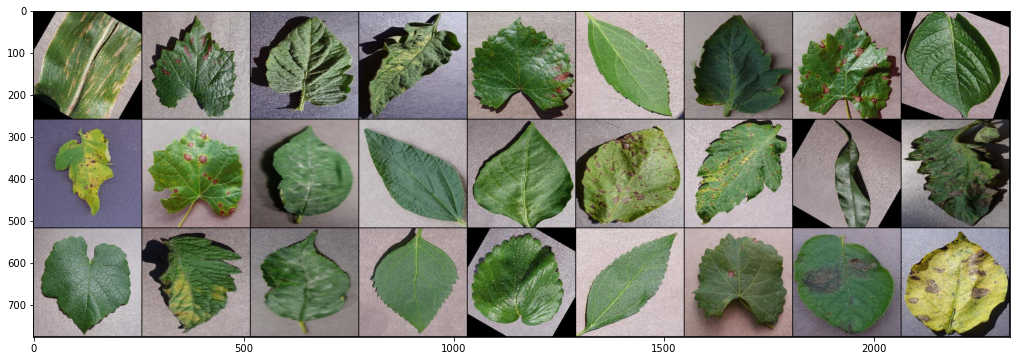

In [5]:
for images,labels in test_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [4]:
##########################################
##  Loading in and Formatting the Data  ##
##########################################

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):
    
    '''
    A function that trains the model and prints out the model accuracy + validation scores at each epoch
    '''
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        accuracies.append(best_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:

########################################
## Loading in the Pre-Trained ResNet  ##
########################################

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

########################
##  Model Parameters  ##
########################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




In [97]:
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

In [98]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

In [100]:
image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [101]:
accuracies = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 3.7546 Acc: 0.0180
val Loss: 3.7512 Acc: 0.0380

Epoch 1/4
----------
train Loss: 3.4690 Acc: 0.0800
val Loss: 3.5969 Acc: 0.0760

Epoch 2/4
----------
train Loss: 3.1244 Acc: 0.2200
val Loss: 3.4177 Acc: 0.1160

Epoch 3/4
----------
train Loss: 2.8043 Acc: 0.3740
val Loss: 3.1832 Acc: 0.2120

Epoch 4/4
----------
train Loss: 2.4883 Acc: 0.5340
val Loss: 2.9371 Acc: 0.3460

Training complete in 19m 29s
Best val Acc: 0.346000


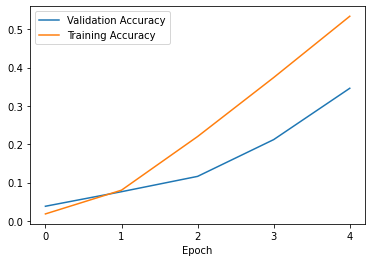

In [41]:
plt.plot([0,1,2,3,4], [0.0380, 0.0760, 0.1160, 0.2120, 0.3460], label = "Validation Accuracy")
plt.plot([0,1,2,3,4], [0.0180, 0.0800, 0.2200, 0.3740, 0.5340], label = "Training Accuracy")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 5, 1))
plt.legend(loc="upper left")

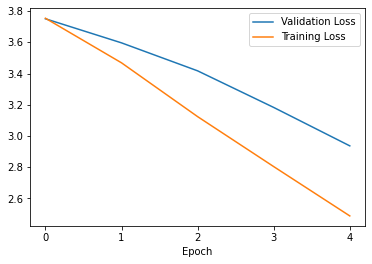

In [42]:
plt.plot([0,1,2,3,4], [3.7512, 3.5969, 3.4177, 3.1832, 2.9371], label = "Validation Loss")
plt.plot([0,1,2,3,4], [3.7546, 3.4690, 3.1244, 2.8043, 2.4883], label = "Training Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 5, 1))
plt.legend(loc="upper right")

### Normalizing Data

In [7]:
##################################
##  Transformation Composition  ##
##################################

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [8]:
data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)


data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)


In [9]:
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

In [10]:
image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


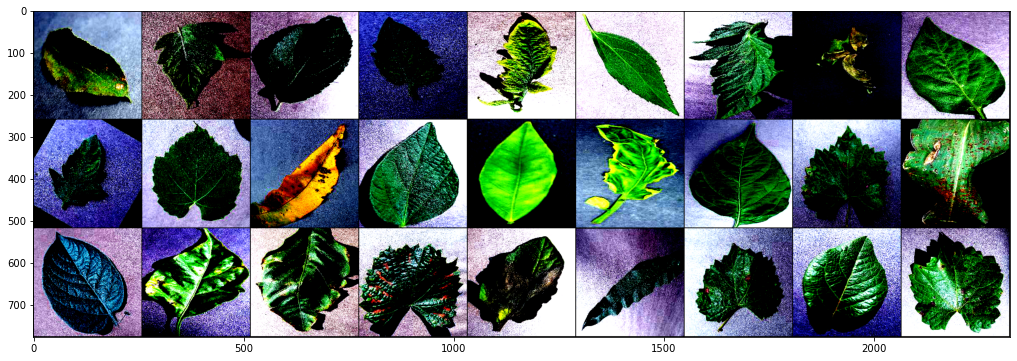

In [29]:
for images,labels in train_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [43]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.1766 Acc: 0.9900
val Loss: 0.2805 Acc: 0.9300

Epoch 1/3
----------
train Loss: 0.1441 Acc: 0.9920
val Loss: 0.2585 Acc: 0.9280

Epoch 2/3
----------
train Loss: 0.1078 Acc: 0.9900
val Loss: 0.2657 Acc: 0.9320

Epoch 3/3
----------
train Loss: 0.1105 Acc: 1.0000
val Loss: 0.2469 Acc: 0.9340

Training complete in 15m 16s
Best val Acc: 0.934000


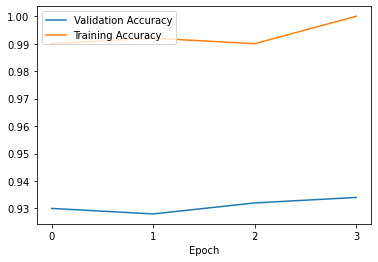

In [43]:
plt.plot([0,1,2,3], [0.9300, 0.9280, 0.9320, 0.9340], label = "Validation Accuracy")
plt.plot([0,1,2,3], [0.9900, 0.9920, 0.9900, 1.0000], label = "Training Accuracy")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 4, 1))
plt.legend(loc="upper left")

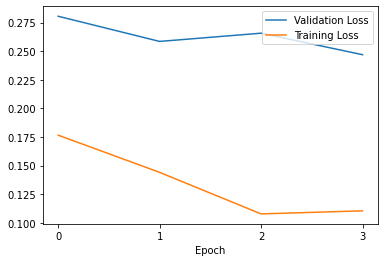

In [44]:
plt.plot([0,1,2,3], [0.2805, 0.2585, 0.2657, 0.2469], label = "Validation Loss")
plt.plot([0,1,2,3], [0.1766, 0.1441, 0.1078, 0.1105], label = "Training Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 4, 1))
plt.legend(loc="upper right")

### Adam Optimizer

The previous models were trained using a stochastic gradient descent optimizer. We will now try the Adam optimizer to see if this produces better results:

In [48]:
########################
##  Model Parameters  ##
########################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
accuracies = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 2.4355 Acc: 0.3760
val Loss: 2.2060 Acc: 0.4500

Epoch 1/3
----------
train Loss: 1.4902 Acc: 0.5520
val Loss: 4.4766 Acc: 0.2820

Epoch 2/3
----------
train Loss: 1.1000 Acc: 0.6580
val Loss: 3.8148 Acc: 0.3480

Epoch 3/3
----------
train Loss: 0.8016 Acc: 0.7360
val Loss: 1.9255 Acc: 0.5160

Training complete in 16m 35s
Best val Acc: 0.516000


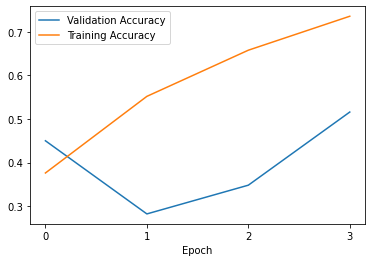

In [45]:
plt.plot([0,1,2,3], [0.4500, 0.2820, 0.3480, 0.5160], label = "Validation Accuracy")
plt.plot([0,1,2,3], [0.3760, 0.5520, 0.6580, 0.7360], label = "Training Accuracy")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 4, 1))
plt.legend(loc="upper left")

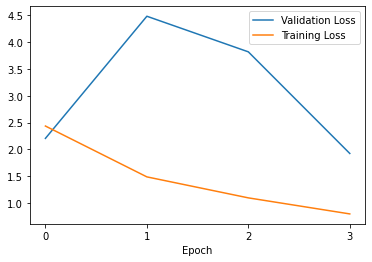

In [46]:
plt.plot([0,1,2,3], [2.2060, 4.4766, 3.8148, 1.9255], label = "Validation Loss")
plt.plot([0,1,2,3], [2.4355, 1.4902, 1.1000, 0.8016], label = "Training Loss")
plt.xlabel("Epoch")
plt.xticks(np.arange(0, 4, 1))
plt.legend(loc="upper right")

### Tuning Batch Size 

The following code chunks were used to find the optimal step size. Unfortunately, I lost all of my outputs last minute whilst simultaneously having a power line breaking outside of my house, frying many electronics and halting my progress. For these reasons, I did not have time to re-run the models, but the batch size which performed best was batch size = 8. 

In [89]:
########################
##  Model Parameters  ##
########################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [88]:
test_loader = DataLoader(
    test_dataset,
    batch_size=5,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=5,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=6,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=6,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
accuracies = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=7,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=7,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
accuracies = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=9,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=9,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
accuracies = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

## Tuning Learning Rate

Similar to the tuning performed for batch size above, the following code was used to select the optimal learning rate. Of the learning rates 0.0001, 0.001, and 0.01, the learning rate 0.001 performed the best. Again, I lost all of my outputs and was unable to re-run in time.

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
########################
##  Model Parameters  ##
########################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

In [ ]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

## Transformations

Tranformations were performed on the data to test if we could get higher validation accuracy using randomly transformed images. Tranformations include random rotations, horizontal flips, and padding. The validation accuracy converged towards about 86%, worse than without the transformations, which resulted in convergence towards approximately 93%.

In [ ]:
##################################
##  Transformation Composition  ##
##################################

transforms_train = transforms.Compose([
    transforms.Pad(25, padding_mode='symmetric'),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [ ]:
data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)


data_path = '/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)


test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

########################
##  Model Parameters  ##
########################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


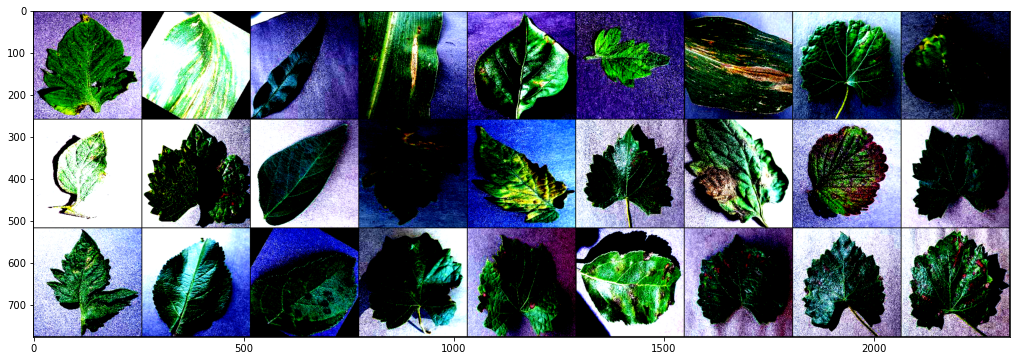

In [74]:
for images,labels in train_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

## Random Forest

In [78]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        if np.random.randint(30) == 0:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
            img = cv2.resize(img, (25, 25))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            train_images.append(img)
            train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [79]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        if np.random.randint(30) == 0:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (25, 25))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            test_images.append(img)
            test_labels.append(label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [80]:
x_train.shape

(2274, 25, 25, 3)

In [81]:
x_test.shape

(596, 25, 25, 3)

### Tuning Parameters

In [84]:
estimators = [10, 50, 100]
depths = [2, 10, None]
min_sample_splits = [2, 3, 5]

In [85]:
for estimator in estimators:
    for depth in depths:
        for min_split in min_sample_splits:
            forest = RandomForestClassifier(n_estimators = estimator, random_state=0, min_samples_split = min_split, max_depth = depth)

            scores = cross_val_score(forest, x_train.reshape(2274, 25*25*3), y_train, cv=5)
            
            print("Number of trees: "+ str(estimator))
            print("Max depth: "+str(depth))
            print("Minimum samples to split node: "+str(min_split))
            print(sum(scores)/len(scores))
            print('-'*60)




Number of trees: 10
Max depth: 2
Minimum samples to split node: 2
0.10157912572009486
------------------------------------------------------------
Number of trees: 10
Max depth: 2
Minimum samples to split node: 3
0.10157912572009486
------------------------------------------------------------
Number of trees: 10
Max depth: 2
Minimum samples to split node: 5
0.10157912572009486
------------------------------------------------------------
Number of trees: 10
Max depth: 10
Minimum samples to split node: 2
0.25374642978167206
------------------------------------------------------------
Number of trees: 10
Max depth: 10
Minimum samples to split node: 3
0.25637991963983153
------------------------------------------------------------
Number of trees: 10
Max depth: 10
Minimum samples to split node: 5
0.25153604105145955
------------------------------------------------------------
Number of trees: 10
Max depth: None
Minimum samples to split node: 2
0.23703538751996903
--------------------------

The best model out of the different combinations of hyperparameters is the model with:  

Number of trees: 100  
Max depth: None  
Min samples to split node: 2  

with an accuracy of 42.4%. Let's train all of the data, with these parameters.

In [93]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (25, 25))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [94]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/Users/kevinhowlett/Downloads/Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (25, 25))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [95]:
x_train.shape

(67848, 25, 25, 3)

In [96]:
x_test.shape

(16973, 25, 25, 3)

### Training Forest on all Images

In [97]:
forest = RandomForestClassifier(n_estimators = 100, random_state=0, min_samples_split = 2, max_depth = None).fit(x_train.reshape(67848, 25*25*3), y_train)


### Forest Accuracy
The accuracy of the best forest model trained on all the data is 65.1%, as shown below:

In [98]:
y_pred = forest.predict(x_test.reshape(16973, 25*25*3))

accuracy_score(y_test, y_pred)

0.6507394096506216

### Forest F-scores

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       504
           1       0.64      0.64      0.64       497
           2       0.69      0.59      0.64       440
           3       0.58      0.67      0.62       502
           4       0.67      0.74      0.71       454
           5       0.58      0.61      0.60       421
           6       0.64      0.86      0.73       456
           7       0.81      0.58      0.67       355
           8       1.00      1.00      1.00       477
           9       0.60      0.87      0.71       423
          10       0.00      0.00      0.00        14
          11       0.55      0.65      0.60       472
          12       0.66      0.75      0.70       480
          13       0.81      0.87      0.84       430
          14       0.65      0.78      0.71       423
          15       0.68      0.82      0.75       503
          16       0.66      0.69      0.68       459
          17       0.74    

/Users/kevinhowlett/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



The final random forest model ended up having an accuracy of 65.1%, when trained on all of the images. The weighted average f1-score was 0.64, meaning the model was fairly well balanced at predicting each class.

## Summary

The overall best model was the ResNet-18 transfer model. When using a batch size of 8, learning rate of 0.001, normalization to the ImageNet data, and stochastic gradient descent, we got a validation accuracy of 93.4%. Using a random forest, we were able to get a better validation accuracy than I imagined we would, considerin the images were heavily compressed to 25x25 (from original 256x256). The validation accuracy of the forest was 65.1% (considerably lower than the CNN, but still decent for how crude the model is and how many classes are present (38)).  